<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Content</center></h1> 

[1. Imports](#1)
    
[2. Data Preprocessing](#2)    

[3. Model Implementations](#3)     

[4. Evaluation](#4)     
    
[5. Conclusion ](#5)
    
[6. Thank You](#6)   
 <a id="1"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Imports</center></h1> 
    
# Imports

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

<a id="2"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Data Preprocessing</center></h1> 
    
# Data Preprocessing

In [2]:
class_names = ['Benign', 'G3', 'G4', 'G5'] 

BASE_DIR = '/kaggle/input/prostate-classification-ukm/Prostate/'

n_benign = len(os.listdir(BASE_DIR + 'Benign'))
n_g3 = len(os.listdir(BASE_DIR + 'G3'))
n_g4 = len(os.listdir(BASE_DIR + 'G4'))
n_g5 = len(os.listdir(BASE_DIR + 'G5'))
n_images = [n_benign, n_g3, n_g4, n_g5]
px.pie(names=class_names, values=n_images)

**Now let's create directories for training and validation**

In [3]:
try:
    os.mkdir('/tmp/prostate')
    os.mkdir('/tmp/prostate/training')
    os.mkdir('/tmp/prostate/validation')
    os.mkdir('/tmp/prostate/test')
    os.mkdir('/tmp/prostate/training/benign')
    os.mkdir('/tmp/prostate/training/g3')
    os.mkdir('/tmp/prostate/training/g4')
    os.mkdir('/tmp/prostate/training/g5')
    os.mkdir('/tmp/prostate/validation/benign')
    os.mkdir('/tmp/prostate/validation/g3')
    os.mkdir('/tmp/prostate/validation/g4')
    os.mkdir('/tmp/prostate/validation/g5')
    os.mkdir('/tmp/prostate/test/benign')
    os.mkdir('/tmp/prostate/test/g3')
    os.mkdir('/tmp/prostate/test/g4')
    os.mkdir('/tmp/prostate/test/g5')
except OSError:
    print('Error failed to make directory')

In [4]:
# Define data path
BENIGN_DIR = BASE_DIR + 'Benign'
G3_DIR = BASE_DIR + 'G3'
G4_DIR = BASE_DIR + 'G4'
G5_DIR = BASE_DIR + 'G5'

TRAINING_DIR = "/tmp/prostate/training/"
VALIDATION_DIR = "/tmp/prostate/validation/"
TEST_DIR = "/tmp/prostate/test/"

TRAINING_BENIGN = os.path.join(TRAINING_DIR, "benign/")
VALIDATION_BENIGN = os.path.join(VALIDATION_DIR, "benign/")

TRAINING_G3 = os.path.join(TRAINING_DIR, "g3/")
VALIDATION_G3 = os.path.join(VALIDATION_DIR, "g3/")

TRAINING_G4 = os.path.join(TRAINING_DIR, "g4/")
VALIDATION_G4 = os.path.join(VALIDATION_DIR, "g4/")

TRAINING_G5 = os.path.join(TRAINING_DIR, "g5/")
VALIDATION_G5 = os.path.join(VALIDATION_DIR, "g5/")

# Define whether to include test split or not
INCLUDE_TEST = True

In [5]:
print(len(os.listdir(TRAINING_DIR + 'benign')))
print(len(os.listdir(TRAINING_DIR + 'g3')))
print(len(os.listdir(TRAINING_DIR + 'g4')))
print(len(os.listdir(TRAINING_DIR + 'g5')))

print(len(os.listdir(VALIDATION_DIR + 'benign')))
print(len(os.listdir(VALIDATION_DIR + 'g3')))
print(len(os.listdir(VALIDATION_DIR + 'g4')))
print(len(os.listdir(VALIDATION_DIR + 'g5')))

print(len(os.listdir(TEST_DIR + 'benign')))
print(len(os.listdir(TEST_DIR + 'g3')))
print(len(os.listdir(TEST_DIR + 'g4')))
print(len(os.listdir(TEST_DIR + 'g5')))

0
0
0
0
0
0
0
0
0
0
0
0


**Now let's create  a function to split the   data**

In [6]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.9):
    """
    Splits the data into train validation and test sets (optional)

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    test_dir (string):  path to be used for test
    include_test_split (boolen):  whether to include a test split or not
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    split_valid_test = int(split + (len(shuffled_files)-split)/2)
   
    if include_test_split:
        validation = shuffled_files[split:split_valid_test] # validation split
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element)) # copy files into test directory
    print("Split sucessful!")

**Now let's call the function to create the  training/validation data**

In [7]:
split_data(BENIGN_DIR, TRAINING_DIR + 'benign', VALIDATION_DIR + 'benign', TEST_DIR + 'benign',INCLUDE_TEST, 0.9)
split_data(G3_DIR, TRAINING_DIR + 'g3', VALIDATION_DIR + 'g3',TEST_DIR + 'g3',INCLUDE_TEST, 0.9)
split_data(G4_DIR, TRAINING_DIR + 'g4', VALIDATION_DIR + 'g4',TEST_DIR + 'g4',INCLUDE_TEST, 0.9)
split_data(G5_DIR, TRAINING_DIR + 'g5', VALIDATION_DIR + 'g5',TEST_DIR + 'g5',INCLUDE_TEST, 0.9)

Split sucessful!
Split sucessful!
Split sucessful!
Split sucessful!


**As a sanity check let's check the data directories**

In [8]:
print(len(os.listdir(TRAINING_DIR + 'benign')))
print(len(os.listdir(TRAINING_DIR + 'g3')))
print(len(os.listdir(TRAINING_DIR + 'g4')))
print(len(os.listdir(TRAINING_DIR + 'g5')))

print(len(os.listdir(VALIDATION_DIR + 'benign')))
print(len(os.listdir(VALIDATION_DIR + 'g3')))
print(len(os.listdir(VALIDATION_DIR + 'g4')))
print(len(os.listdir(VALIDATION_DIR + 'g5')))

print(len(os.listdir(TEST_DIR + 'benign')))
print(len(os.listdir(TEST_DIR + 'g3')))
print(len(os.listdir(TEST_DIR + 'g4')))
print(len(os.listdir(TEST_DIR + 'g5')))

46
36
50
39
3
2
3
2
3
3
3
3


## Create Generators

In [9]:
train_gen = ImageDataGenerator(
        rescale=1./255)


validation_gen =  ImageDataGenerator(
        rescale=1./255.)

test_gen =  ImageDataGenerator(
            rescale=1./255.)


In [10]:
train_generator = train_gen.flow_from_directory(
        TRAINING_DIR,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')
validation_generator = validation_gen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

test_generator = test_gen.flow_from_directory(
        TEST_DIR,
        target_size=(150, 150),
        batch_size=64,
        class_mode='binary')

Found 171 images belonging to 4 classes.
Found 10 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


**Now let's make sure we got the correct data**

In [11]:
def plot_data(generator, n_images):
    """
    Plots random data from dataset
    Args:
    generator: a generator instance
    n_images : number of images to plot
    """
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

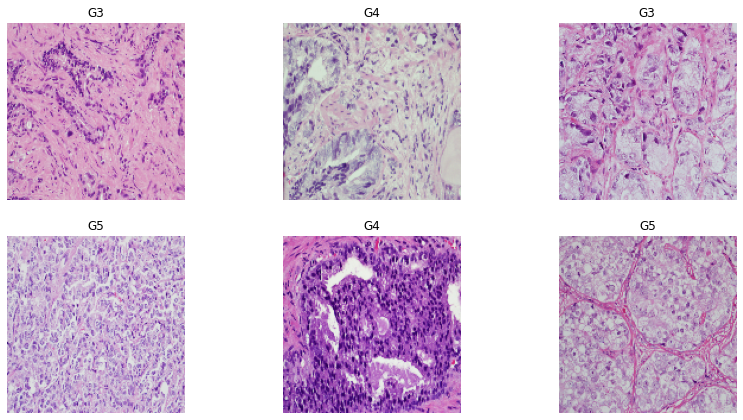

In [12]:
plot_data(train_generator,7)

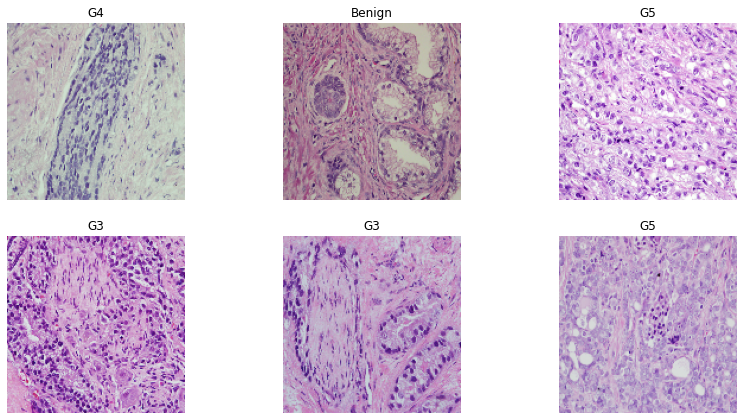

In [13]:
plot_data(validation_generator,7)

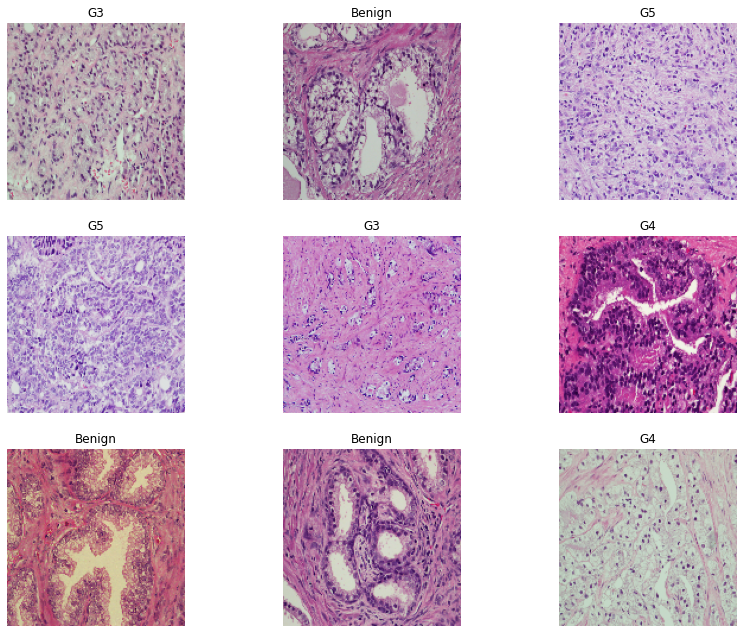

In [14]:
plot_data(test_generator, 10)

**Great, now that the data is ready let's train our model**

<a id="3"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Model Implementations</center></h1> 
    
# Model Implementations

In [15]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

2023-01-08 11:39:41.508032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 11:39:41.512029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 11:39:41.512785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 11:39:41.514536: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
len(model.layers)

12

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 69, 69, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0     

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [19]:
r = model.fit(
        train_generator,
        epochs=10,# Training longer could yield better results
        validation_data=validation_generator)

2023-01-08 11:39:46.833007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-08 11:39:51.400750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3/3 [==============================] - 19s 4s/step - loss: 3.6185 - accuracy: 0.2515 - val_loss: 1.3819 - val_accuracy: 0.3000
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 1.3981 - accuracy: 0.2456 - val_loss: 1.3816 - val_accuracy: 0.3000
Epoch 3/10
3/3 [==============================] - 6s 2s/step - loss: 1.3900 - accuracy: 0.2924 - val_loss: 1.3833 - val_accuracy: 0.3000
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 1.3850 - accuracy: 0.2164 - val_loss: 1.3794 - val_accuracy: 0.3000
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 1.3844 - accuracy: 0.2924 - val_loss: 1.3781 - val_accuracy: 0.3000
Epoch 6/10
3/3 [==============================] - 6s 2s/step - loss: 1.3859 - accuracy: 0.2924 - val_loss: 1.3774 - val_accuracy: 0.3000
Epoch 7/10
3/3 [==============================] - 5s 1s/step - loss: 1.3863 - accuracy: 0.2924 - val_loss: 1.3771 - val_accuracy: 0.3000
Epoch 8/10
3/3 [==============================] - 5

<a id="4"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Evaluation</center></h1> 
    
# Evaluation

## Evaluate the model on the test set

In [20]:
loss_test, acc_test = model.evaluate(test_generator)
loss_val, acc_val = model.evaluate(validation_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model.save("baseline_model.h5")

1/1 [==============================] - 0s 346ms/step - loss: 1.3681 - accuracy: 0.3000
Validation: accuracy = 0.300000  ;  loss_v = 1.368083
Test: accuracy = 0.250000  ;  loss = 1.383368


## Visualize the predicitons

In [21]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

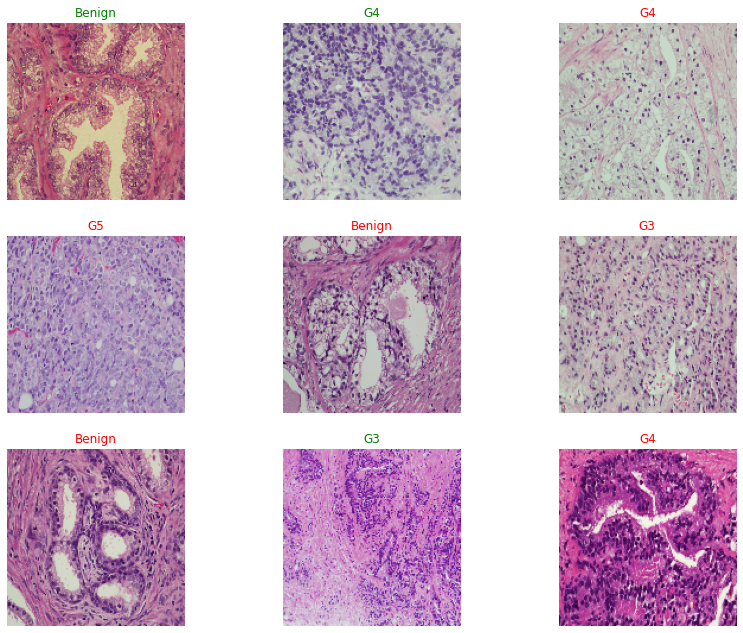

In [22]:
plot_prediction(test_generator, 10)

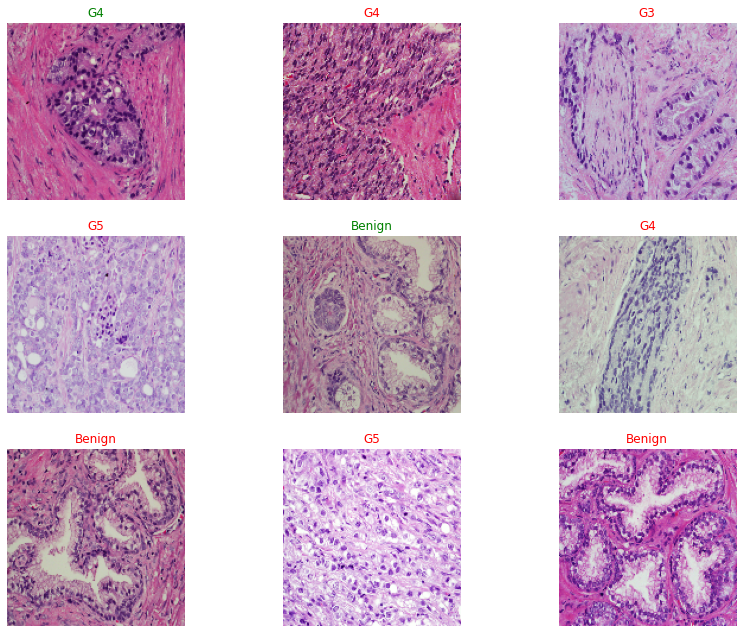

In [23]:
plot_prediction(validation_generator, 10)

## Visualize the activation maps

In [24]:
# Create a  model to visualize activation maps
gp_weights =  model.get_layer('dense').get_weights()[0]
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [25]:
# Use the model to make predictions on the test generator
images, _ = test_generator.next()
features, results = activation_model.predict(images)

In [26]:
def show_cam(image_index, features, results):
    """
    Shows activation maps
    Args:
    image_index: index of image
    features: the extracted features
    results: model's predictions
    """
    # takes the features of the chosen image
    features_for_img = features[image_index,:,:,:]

    # get the class with the highest output probability
    prediction = np.argmax(results[image_index])

    # get the gap weights at the predicted class
    class_activation_weights = gp_weights[:,prediction]

    # upsample the features to the image's original size (150 x 150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    print('Predicted Class = ' +str(class_names[prediction])+ ', Probability = ' + str(results[image_index][prediction]))

    # show the upsampled image
    
    plt.imshow(images[image_index])

    # strongly classified (95% probability) images will be in green, else red
    if results[image_index][prediction]>0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # overlay the cam output
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # display the image
    plt.show()

In [27]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates Cam activation maps
    Args:
    desired_class: class to show the maps for
    num_maps: number of maps to be generated 
    '''
    counter = 0
    # go through the first 10 images
    for i in range(0,10):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i,features, results)

In [28]:
results

array([[0.26302835, 0.2202514 , 0.27887085, 0.2378494 ],
       [0.25716907, 0.21965073, 0.27989268, 0.24328752],
       [0.25711197, 0.22008452, 0.2793619 , 0.24344163],
       [0.26145026, 0.21969636, 0.27942044, 0.23943295],
       [0.26046583, 0.22003326, 0.27911422, 0.24038668],
       [0.26780602, 0.21937579, 0.27949208, 0.23332615],
       [0.25886688, 0.21999809, 0.27947807, 0.24165696],
       [0.26435313, 0.2201218 , 0.27894738, 0.23657775],
       [0.26026464, 0.22056155, 0.27861536, 0.24055848],
       [0.25901055, 0.22118624, 0.27794775, 0.2418554 ],
       [0.267979  , 0.21962702, 0.27957392, 0.23282008],
       [0.26116636, 0.21985589, 0.27947184, 0.23950584]], dtype=float32)

In [29]:
show_maps(desired_class=1, num_maps=5)
show_maps(desired_class=0, num_maps=5)

In [30]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  1.385916  0.292398  1.377399           0.3
6  1.386274  0.292398  1.377068           0.3
7  1.380327  0.292398  1.376133           0.3
8  1.377091  0.292398  1.379198           0.3
9  1.382715  0.239766  1.368083           0.3

## Visualize training process

In [31]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [32]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

**Let's try using data augmentation**

# Data Augmentation 

In [33]:
train_gen_aug = ImageDataGenerator(
        rescale=1./255,fill_mode='nearest',horizontal_flip=True,
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug =  ImageDataGenerator(
        rescale=1./255.)

In [34]:
train_generator = train_gen_aug.flow_from_directory(
        TRAINING_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
        VALIDATION_DIR,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 171 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


In [35]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x) 
x = tf.keras.layers.Dense(5, activation='softmax')(x) 

model_aug = Model(inputs=inputs, outputs=x)

In [36]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [37]:
r = model_aug.fit(
        train_generator,
        epochs=10,#Training longer could yield better results
        validation_data=validation_generator)

Epoch 1/10
6/6 [==============================] - 7s 979ms/step - loss: 12.6378 - accuracy: 0.2632 - val_loss: 1.4692 - val_accuracy: 0.3000
Epoch 2/10
6/6 [==============================] - 6s 994ms/step - loss: 1.4722 - accuracy: 0.2398 - val_loss: 1.3834 - val_accuracy: 0.3000
Epoch 3/10
6/6 [==============================] - 7s 1s/step - loss: 1.4566 - accuracy: 0.2164 - val_loss: 1.3991 - val_accuracy: 0.3000
Epoch 4/10
6/6 [==============================] - 6s 882ms/step - loss: 1.4091 - accuracy: 0.2632 - val_loss: 1.4132 - val_accuracy: 0.2000
Epoch 5/10
6/6 [==============================] - 7s 1s/step - loss: 1.3929 - accuracy: 0.2690 - val_loss: 1.5754 - val_accuracy: 0.2000
Epoch 6/10
6/6 [==============================] - 6s 976ms/step - loss: 1.4311 - accuracy: 0.2456 - val_loss: 1.3657 - val_accuracy: 0.3000
Epoch 7/10
6/6 [==============================] - 6s 1s/step - loss: 1.6115 - accuracy: 0.2281 - val_loss: 1.3974 - val_accuracy: 0.3000
Epoch 8/10
6/6 [============

In [38]:
loss_test, acc_test = model_aug.evaluate(test_generator)
loss_val, acc_val = model_aug.evaluate(validation_generator)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))
model_aug.save("baseline_model_aug.h5")

1/1 [==============================] - 0s 361ms/step - loss: 1.4219 - accuracy: 0.2000
Validation: accuracy = 0.200000  ;  loss_v = 1.421912
Test: accuracy = 0.250000  ;  loss = 1.396278


2023-01-08 11:42:16.065926: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 235929600 exceeds 10% of free system memory.
2023-01-08 11:42:16.855474: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 235929600 exceeds 10% of free system memory.


In [39]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  1.431067  0.245614  1.365705           0.3
6  1.611498  0.228070  1.397376           0.3
7  1.398868  0.257310  1.382306           0.3
8  1.390453  0.222222  1.430253           0.3
9  1.669274  0.257310  1.421911           0.2

In [40]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [41]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

<a id="5"></a>
<h1 style='background:#fad25a;padding-top:17px; border:0; color:black'><center>Conclusion</center></h1> 
    
# Conclusion

**Using data augmentation with these hyper-parameters gave us worse results**


**We can Use [transfer learning](https://www.kaggle.com/code/fareselmenshawii/introdution-to-transfer-learning/edit/run/109466477) or a more complex architecture to solve this problem**